In [118]:
import torch
import json
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
import math
import torch.nn.functional as F
import pickle
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
MAX_LENGTH=25
CUDA=torch.cuda.is_available()
CUDA=False
device=torch.device("cuda:7" if CUDA else "cpu")

In [119]:
with open('/mnt/disk1/Gulshan/rnn/transformer/WORDMAP_corpus.json','r') as f:
    word_map=json.load(f)
pairs_path=r'/mnt/disk1/Gulshan/rnn/transformer/pairs_encoded.json'

# Dataset

In [120]:
class transformer_dataset(Dataset):
    def __init__(self,paris_path) -> None:
        self.pairs=json.load(open(paris_path))
        self.dataset_len=len(self.pairs)
        print(self.dataset_len)
    def __len__(self):
        return self.dataset_len
    
    def __getitem__(self, index):
        ques=torch.LongTensor(self.pairs[index][0])
        # long tensor 64 bit signed interger based tensor so most of computers are 64 bit
        anws=torch.LongTensor(self.pairs[index][1])
        return ques,anws

In [121]:
ex1=transformer_dataset(pairs_path)

221616


In [122]:
train_loader=DataLoader(ex1,batch_size=120,shuffle=True)
x,y=next(iter(train_loader))
x.shape,y.shape #->(torch.Size([64, 25]), torch.Size([64, 27])) 27 because of start and end token but max lenght is 25

(torch.Size([120, 25]), torch.Size([120, 27]))

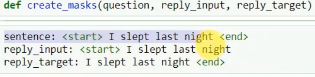

In [123]:
size=5
print(torch.ones(size,size))
print(torch.triu(torch.ones(size,size)))
print(torch.triu(torch.ones(size,size)).transpose(0,1))
print(torch.tril(torch.ones(5,5)))

tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])
tensor([[1., 1., 1., 1., 1.],
        [0., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 1.]])
tensor([[1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1.]])
tensor([[1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1.]])


In [124]:
q,a=next(iter(train_loader))
print(q[0])
print(type(q[0]))
x=q[0]!=0
print([int(elem) for elem in x])
m=q[0]!=0
print(m.bool())
m=m.long()
m.unsqueeze(1)
print(m.long())
print(type(m))
print(m.shape)
print(m.unsqueeze(0))
print(m.shape)



tensor([ 113,  114,   28,  122,  386,   47,   67, 1590,   91,   92,  459,  173,
          20,   76,  432,   28,   16, 4042,   25,   28, 1585,  164, 9648, 2417,
         880])
<class 'torch.Tensor'>
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1])
<class 'torch.Tensor'>
torch.Size([25])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1]])
torch.Size([25])


In [125]:
[1 if i!=0  else 0 for i in q[0]]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [126]:
def create_mask(question,reply_input,reply_target):
    
    def subsequent_mask(size):
        mask=torch.triu(torch.ones(size,size)).transpose(0,1).type(dtype=torch.uint8)
        mask=mask.unsqueeze(0)
        return mask
    question_mask=question!=0
    question_mask=question_mask.long().to(device)
    # question_mask=[1 if i!=0  else 0 for i in question].to(device)
    # question_mask
    question_mask=question_mask.unsqueeze(1).unsqueeze(1)#(bs,1,1,max_words)
    
    # reply_input_mask=[1 if i!=0  else 0 for i in reply_input]
    
    reply_input_mask=reply_input!=0
    reply_input_mask=reply_input_mask.long()
    reply_input_mask=reply_input_mask.unsqueeze(1)# (bs,1,max_word)
    
    reply_input_mask=reply_input_mask & subsequent_mask(reply_input.size(-1)).type_as(reply_input_mask)
    # (bs,max words, max words)
    reply_input_mask=reply_input_mask.unsqueeze(1)
    
    # reply_target_mask=[1 if i!=0  else 0 for i in reply_target]
    reply_target_mask=reply_target!=0
    reply_target_mask=reply_target_mask.long()
    return question_mask,reply_input_mask,reply_target_mask

In [127]:
e=nn.Embedding(5,4)
print(e.weight)
x=torch.LongTensor([2,1,2])
print(x,e(x))
x=torch.LongTensor([0])
print(x,e(x))

Parameter containing:
tensor([[-0.6680,  0.0400,  0.4581,  2.1990],
        [ 1.1431,  0.6324,  1.5736,  0.1649],
        [ 0.0780, -0.3707,  2.5640, -1.3639],
        [ 0.5608,  1.4404,  0.0198, -1.1490],
        [ 0.3415,  0.8883, -1.9623,  0.9339]], requires_grad=True)
tensor([2, 1, 2]) tensor([[ 0.0780, -0.3707,  2.5640, -1.3639],
        [ 1.1431,  0.6324,  1.5736,  0.1649],
        [ 0.0780, -0.3707,  2.5640, -1.3639]], grad_fn=<EmbeddingBackward0>)
tensor([0]) tensor([[-0.6680,  0.0400,  0.4581,  2.1990]], grad_fn=<EmbeddingBackward0>)


In [341]:
class _Embeddings(nn.Module):
    def __init__(self,vocab_size,dim_model,max_len=50) -> None:
        super(_Embeddings,self).__init__()
        self.dim_model=dim_model
        self.embed=nn.Embedding(vocab_size,dim_model)
        self.dropout=nn.Dropout(0.1)
        self.postional_encoding= self.create_postional_encoding(max_len,self.dim_model)
        
    def create_postional_encoding(self,max_len,dim_model):
        print(max_len,dim_model)
        pe = torch.zeros(max_len, dim_model).to(device)
        for pos in range(max_len):
            for i in range(0,dim_model,2):
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i)/dim_model)))
                pe[pos, i + 1] = math.cos(pos / (10000 ** ((2 * (i + 1))/dim_model)))
        pe=pe.unsqueeze(0) #(1,max_len,dime..model)
        
        return pe
    
    def forward(self,encoded_words):
        print("_Embeddings -> embed",self.embed)
        print("encoded type",type(encoded_words))
        x=torch.LongTensor([120,25])
        print(self.embed(x))
        print("x shape",x.shape)
        print("type of Long trnsor",type(x))
        print("_Embeddings -> encodede words",encoded_words.shape)
        embedding=self.embed(encoded_words) * math.sqrt(self.dim_model) #(bs,max words,dim..model)
        print("_EMbedding -> embedding shape",embedding.shape)
        embedding += self.postional_encoding[:,:embedding.size(1)] # postional encode will automatically expanded to bs as embedding matrix
        print("_EMbedding -> embedding shape",embedding.shape)
        embedding=self.dropout(embedding)
        print("_EMbedding -> embedding shape",embedding.shape)
        return embedding
        

In [342]:
# q=_Embeddings(18243,512)

In [343]:
class multiheadattn(nn.Module):
    def __init__(self,heads,dim_model):
        super(multiheadattn,self).__init__()
        assert dim_model % heads == 0,"can't Operation"
        self.dim_each_head=dim_model//heads
        self.heads=heads
        self.droput=nn.Dropout(0.1)
        self.query=nn.Linear(dim_model,dim_model)
        self.key=nn.Linear(dim_model,dim_model)
        self.value=nn.Linear(dim_model,dim_model)
        self.concat=nn.Linear(dim_model,dim_model)
        
    def forward(self,key,query,value,mask):
        #,key,query,value -> (bs,max words,dim model)
        #mask -> (bs,1,1,max_words)
        query=self.query(query) #(bs,max words,dim model)
        key=self.key(key) #(bs,max words,dim model)
        value=self.value(value) #(bs,max words,dim model)
        
        #(bs,max words,dim model) ->(bs,max words,head,d_k) ->(bs,h,max words,d_k)
        query=query.view(query.shape[0],-1,self.heads,self.dim_each_head).permute(0,2,1,3)        
        key=key.view(query.shape[0],-1,self.heads,self.dim_each_head).permute(0,2,1,3)        
        value=value.view(query.shape[0],-1,self.heads,self.dim_each_head).permute(0,2,1,3)  
        
        # (bs,h,max words,d_k) dot transposed((bs,h,d_k, max words)) -> (bs,h,max word ,max word)
        scores=torch.matmul(query,key.permute(0,1,3,2)) / math.sqrt(self.dim_each_head)
        scores=scores.masked_fill(mask==0,-1e9)
        weights=F.softmax(scores,dim=-1)
        weights=self.droput(weights)
        
        #(bs,h,max word ,max word) dot (value)  (bs,h,max words,d_k) ->(bs,h,max words,d_k)
        context=torch.matmul(weights,value)
        # (bs,h,max word, d_K)--> (bs,max word,h,d_k) -> (bs, max word,h*d_k)
        context=context.permute(0,2,1,3).view(context.shape[0],-1,self.heads*self.dim_each_head)
        concat=self.concat(context)
        return concat
              

In [344]:
# a=torch.randn(2,2)
# _mask=torch.tensor([[1,0],[0,1]])
# print(a)
# print(_mask)
# print(a.masked_fill(_mask==1,12))

# # tensor([[-1.3712, -1.7410],
# #         [-0.7439,  1.2962]])
# # tensor([[1, 0],
# #         [0, 1]])
# # tensor([[12.0000, -1.7410],
# #         [-0.7439, 12.0000]])

In [345]:
class feedforward(nn.Module):
    def __init__(self,dim_model,middel_dim=2048) -> None:
        super(feedforward,self).__init__()
        self.fc1=nn.Linear(dim_model,middel_dim)
        self.fc2=nn.Linear(middel_dim,dim_model)
        self.droput =nn.Dropout(0.1)
    def forward(self,x):
        out=self.fc1(x)
        out=F.relu(out)
        out=self.fc2(self.droput(out))
        return out 

In [346]:
class Encode(nn.Module):
    def __init__(self,heads,dim_model) -> None:
        super(Encode,self).__init__()
        self.self_multihead=multiheadattn(heads,dim_model)
        self.feedfw=feedforward(dim_model)
        self.layer_norm=nn.LayerNorm(dim_model)
        self.droput=nn.Dropout(0.1)
    
    def forward(self,embeddings,mask):
        interacted=self.self_multihead(embeddings,embeddings,embeddings,mask) # query key value mask
        interacted=self.droput(interacted)
        interacted=self.layer_norm(embeddings+embeddings) # residual + layer norm
        feedfw=self.feedfw(interacted)
        feedfw=self.droput(interacted)
        feedfw=feedfw+interacted
        encoded=self.layer_norm(feedfw)
        
        return encoded

In [347]:
class Decode(nn.Module):
    def __init__(self,heads,dim_model):
        super(Decode,self).__init__()
        self.self_multihead=multiheadattn(heads,dim_model)
        self.source_multihead=multiheadattn(heads,dim_model)
        self.feedfw=feedforward(dim_model)
        self.layer_norm=nn.LayerNorm(dim_model)
        self.droput=nn.Dropout(0.1)
    def forward(self,embeddings,encode,soruce_mask,target_mask):
        query=self.self_multihead(embeddings,embeddings,embeddings,target_mask) # query key value mask
        query=self.droput(query)
        query=self.layer_norm(query+embeddings)
        
        interacted=self.droput(self.source_multihead(query,encode,encode.source_mask))
        interacted=self.layer_norm(interacted+query)
        
        feedfw_out=self.droput(self.feedfw(interacted))
        decoded=self.layer_norm(feedfw_out+interacted)
        
        return decoded

In [348]:
class Transformer(nn.Module):
    def __init__(self, heads,dim_model,num_layers,word_map) -> None:
        super(Transformer,self).__init__()
        self.dim_model=dim_model
        self.vocab=len(word_map)
        print('Transformer class len of the vocab',self.vocab)
        print('Transformer class dim model',dim_model)
        self.embed= _Embeddings(self.vocab,dim_model)
        self.encoder=nn.ModuleList([Encode(heads,dim_model) for _ in range(num_layers)])
        self.decoder=nn.ModuleList([Decode(heads,dim_model) for _ in range(num_layers)])
        self.logit=nn.Linear(dim_model,self.vocab)
    
    def encode(self,ques_word,ques_mask):
        print("encode",ques_word.shape)
        print("embed",self.embed)
        ques_embeddings=self.embed(ques_word)
        print('ques_embeddings',ques_embeddings.shape)
        for layer in self.encoder:
            ques_embeddings=layer(ques_embeddings,ques_mask)
        return ques_embeddings
    def decode(self,target_word,target_mask,ques_embedding,ques_mask):
        print("decode",target_word.shape)
        traget_embedding=self.embed(target_word)
        for layer in self.decoder:
            traget_embedding=layer(traget_embedding,ques_embedding,ques_mask,target_mask)
        return traget_embedding
    def forward(self,ques_words,ques_mask,target_word,target_mask):
        encoded=self.encode(ques_words,ques_mask)
        decoded=self.decode(target_word,target_mask,encoded,ques_mask)
        # here we are sunig kl div loss we need to log and apply softmax but in case of cross entropy it automatically applies loga and softmax
        out=F.log_softmax(self.logit(decoded),dim=2) 
        return out
        

In [349]:
class Adamwarmup:
    def __init__(self,model_size,warmup_step,optimizer) -> None:
        self.model_size=model_size
        self.warmup_step=warmup_step
        self.optimizer=optimizer
        self.current_step=0
        self.lr=0
    def get_lr(self):
        return self.model_size ** (-0.5) * min(self.current_step ** (-0.5), self.current_step * self.warmup_steps ** (-1.5))
    def step(self):
        # updating wights
        self.current_step+=1
        lr=self.get_lr()
        for param in self.optimizer.param_groups:
            param['lr']=lr
        self.lr=lr
        self.optimizer.step()

# loss

In [350]:
class loss_label_smooth(nn.Module):
    def __init__(self,size,smooth) -> None:
        super(loss_label_smooth,self).__init__()
        self.criterion=nn.KLDivLoss(size_average=False,reduce=False)
        self.confidence=1-smooth
        self.smooth=smooth
        self.size=size
    def forward(self,prediction,target,mask):
        # predc.. -> (bs,max word,vocab size)
        # target,mask -> (bs,max words)
        prediction=prediction.view(-1,prediction.size(-1))
        target=target.view(-1)
        mask=mask.view(-1)
        labels=prediction.data.clone()
        labels.fill_(self.smooth/(self.size-1))
        labels.scatter_(1,target.data.unsequeeze(1),self.confidence)
        loss=self.criterion(prediction,labels)
        loss=(loss.sum(1)*mask).sum() / mask.sum()
        return loss 
        

In [351]:
# bs,max_word,vocab_size=2,4,2
# pred=torch.randn(2,4,2)# bs,max word ,vocab xsize
# print(pred)
# print(pred.shape)
# pred=pred.view(-1,pred.shape[-1])
# print(pred)
# tar=torch.LongTensor(bs*max_word).random_(0,3)
# print("target shape",tar.shape)
# print(tar)
# mask=tar!=0
# # print(mask)
# mask=[int(elem) for elem in mask]
# print(mask)
# labels=pred.data.clone()
# print(labels)
# print(labels.shape)
# labels.fill_(0.3/vocab_size-1)
# print(labels.fill_(0.3/vocab_size-1))
# print(labels.scatter(1,tar.unsqueeze(1),1-0.3))
# # tensor([[[-0.2510,  1.1390],
# #          [-0.0925,  0.3604],
# #          [-0.6933, -0.3548],
# #          [ 0.4709,  0.1002]],

# #         [[-0.9825, -1.5021],
# #          [ 1.6946, -2.6433],
# #          [-0.0707, -1.3192],
# #          [ 0.4359, -0.1883]]])
# # torch.Size([2, 4, 2])
# # tensor([[-0.2510,  1.1390],
# #         [-0.0925,  0.3604],
# #         [-0.6933, -0.3548],
# #         [ 0.4709,  0.1002],
# #         [-0.9825, -1.5021],
# #         [ 1.6946, -2.6433],
# #         [-0.0707, -1.3192],
# #         [ 0.4359, -0.1883]])
# # target shape torch.Size([8])
# # tensor([1, 0, 1, 1, 2, 0, 0, 2])
# # [1, 0, 1, 1, 1, 0, 0, 1]
# # tensor([[-0.2510,  1.1390],
# #         [-0.0925,  0.3604],
# #         [-0.6933, -0.3548],
# #         [ 0.4709,  0.1002],
# # ...
# #         [-0.8500, -0.8500],
# #         [-0.8500, -0.8500],
# #         [-0.8500, -0.8500],
# #         [-0.8500, -0.8500]])

In [352]:
# bs,max_word,vocab_size=2,4,2
# tar=torch.LongTensor(bs*max_word).random_(0,3)
# mask=tar!=0
# mask=[int(elem) for elem in mask]
# print(mask)
# loss=torch.randn(bs * max_word,vocab_size)# bs,max word ,vocab xsize
# print(loss)
# print(loss.shape)
# print(loss.sum(1))
# print((loss.sum(1)*mask).sum()/mask.sum())

In [353]:
dim_model=512
heads=8
num_layers=1
epochs=1
with open('/mnt/disk1/Gulshan/rnn/transformer/WORDMAP_corpus.json','r') as j:
    word_map=json.load(j)
transfomer=Transformer(heads,dim_model,num_layers,word_map).to(device)
optim=torch.optim.Adam(transfomer.parameters(),lr=0,betas=(0.9,0.98),eps=1e-9)
transformer_optim=Adamwarmup(dim_model,4000,optim)
criteron=loss_label_smooth(len(word_map),smooth=0.3)

Transformer class len of the vocab 18243
Transformer class dim model 512
50 512


/home/antpc/.local/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


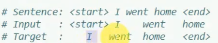

In [354]:
def train(train_loader,transfomer,criteron,epoch):
    transfomer.train()
    sum_loss=0
    count=0
    for i,(q,a) in enumerate(train_loader):
        samples=q.shape[0]
        q=q.to(device)
        a=a.to(device)
        print(q.shape,a.shape)
        a_input=a[:,:-1] # start to last word
        a_target=a[:,1:] # firts word to end token
        print(a_input.shape)
        print(a_target.shape)
        question_mask,reply_input_mask,reply_target_mask=create_mask(q,a_input,a_target)
        # run thrguh trsnformer
        print(q.shape,question_mask.shape,a_input.shape,reply_input_mask.shape)
        out=transfomer(q,question_mask,a_input,reply_input_mask)
        print(out.shape)
        loss=criteron(out,a_target,reply_target_mask)
        
        transformer_optim.optimizer.zero_grad()
        loss.backward()
        transformer_optim.optimizer.step()
        
        sum_loss+=loss.item() * samples
        count+=samples
        
        if i%100==0:
            print("Epoch [{}][{}/{}]\tLoss: {:.3f}".format(epoch, i, len(train_loader), sum_loss/count))     

In [355]:
for epoch in range(epochs):
    train(train_loader,transfomer,criteron,epoch)
    state = {'epoch': epoch, 'transformer': transfomer, 'transformer_optimizer': transformer_optim}
    torch.save(state, 'checkpoint_' + str(epoch) + '.pth.tar')

torch.Size([120, 25]) torch.Size([120, 27])
torch.Size([120, 26])
torch.Size([120, 26])
torch.Size([120, 25]) torch.Size([120, 1, 1, 25]) torch.Size([120, 26]) torch.Size([120, 1, 26, 26])
encode torch.Size([120, 25])
embed _Embeddings(
  (embed): Embedding(18243, 512)
  (dropout): Dropout(p=0.1, inplace=False)
)
_Embeddings -> embed Embedding(18243, 512)
encoded type <class 'torch.Tensor'>
tensor([[-0.7119, -1.0810, -0.3982,  ...,  0.9917,  0.8540,  0.6611],
        [ 0.5392, -0.1458, -0.1348,  ..., -0.9701, -0.1079, -0.0900]],
       grad_fn=<EmbeddingBackward0>)
x shape torch.Size([2])
type of Long trnsor <class 'torch.Tensor'>
_Embeddings -> encodede words torch.Size([120, 25])


IndexError: index out of range in self

In [340]:
def evalute(transfomer,question,question_mask,max_len,word_map):
    # performs greedy search with bs of 1
    transfomer.eval()
    rev_wordmap={v:k for k,v in word_map.items()}
    start_token=word_map['<start>']
    encoded=transfomer.encode(question,question_mask)
    words=torch.LongTensor([[start_token]]).to(device)
    
    for step in range(max_len-1):
        size=words.shape[0]
        target_mask = torch.triu(torch.ones(size, size)).transpose(0, 1).type(dtype=torch.uint8)
        target_mask = target_mask.to(device).unsqueeze(0).unsqueeze(0)
        decoded=transfomer.decode(words,target_mask,encoded,question_mask)
        #decoded shape -> (1,1,vocabsize)
        prediction=transfomer.logit(decoded[:-1])
        #prediciton shape -> (1,vocab size)
        _, next_word = torch.max(prediction, dim = 1)
        next_word=next_word.item()
        if next_word==word_map['<END>']:
            break
        words=torch.cat([words,torch.LongTensor([[next_word]]).to(device)],dim=1) # (1,step+2)
        
    # (1,5)
    words=words.squeeze(0) # 1 dim
    words=words.tolist()
    
    sentence_idx=[w for w in words if w not in {word_map['<start>']}]
    sentence = ' '.join([rev_wordmap[sentence_idx[k]] for k in range(len(sentence_idx))])
    
    return sentence
        

In [ ]:
checkpoint = torch.load('checkpoint.pth.tar')
transformer = checkpoint['transformer']

In [ ]:
while(1):
    question=input()
    if question=='q' or question'quit':
        break
    max_len=input('Enter max words to be generated')
    enc_qus = [word_map.get(word, word_map['<unk>']) for word in question.split()]
    question = torch.LongTensor(enc_qus).to(device).unsqueeze(0)
    question_mask = (question!=0)
    question_mask=[int(elem) for elem in question_mask].to(device).unsqueeze(1).unsqueeze(1)
    sentence = evalute(transformer, question, question_mask, int(max_len), word_map)
    print(sentence)